## Пункт 1. Реализовать СГС для решения ЛР. Исследовать сходимость с разным размером батча

In [25]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [26]:
# linear function, computes k-th coordinate by k-1 first
#   coefficients - k-1-dim array
#   x - k-1-dim array
def f(coefficients, x):
    return np.sum(coefficients * x)

# scale coord array into [0; 1] interval
def scale_dim(coords):
    mn = coords[0]
    mx = coords[0]
    for i in range(0, len(coords)):
        mn = min(mn, coords[i])
        mx = max(mx, coords[i])
    if mn == mx:
        for i in range(0, len(coords)):
            coords[i] = 0
    else:
        for i in range(0, len(coords)):
            coords[i] = (coords[i] - mn) / (mx - mn)
    return [coords, mn, mx]

# scale all point_set coords into [0; 1] interval
def apply_scaling(points):
    x = points.x.copy()
    y = points.y.copy()
    for k in range(0, points.dim - 1):
        coords = np.asarray([])
        for i in range(0, points.n):
            coords = np.append(coords, points.x[i][k])
        coords = scale_dim(coords)[0]
        for i in range(0, points.n):
            x[i][k] = coords[i]
    y = scale_dim(y)[0] 
    return point_set(points.n, points.dim, x, y)

class point_set:
    # copy ctor :|
    def __init__(self, n, dim, x, y):
        self.n = n
        self.dim = dim
        self.x = x
        self.y = y

# create point_set:
# n - amount of points
# dim - space's dim
# coords_bound - upper bound on absolute first k-1 coordinates value
# coefficients_bound - upper bound on absolute coefficients value
def create_point_set(n, dim, coords_bound, coefficients_bound, coefficients = []):
    x = coords_bound * np.random.random_sample((n, dim - 1))
    if coefficients == []:
        coefficients = coefficients_bound * np.random.random_sample((dim - 1)) - coefficients_bound
    else:
        coefficients = np.asarray(coords_bound)
    y = np.asarray([])
    for i in range(0, n):
        y = np.append(y, f(coefficients, x[i]))
    return point_set(n, dim, x, y)

input_2d = create_point_set(200, 2, 10., 2.)
input_3d = create_point_set(200, 3, 10., 2.)
input_small = create_point_set(25, 5, 20., 1.)
input_large = create_point_set(100, 20, 30., 2.)
input_wild = create_point_set(5, 10, 1000., 1.)
input_custom = create_point_set(200, 2, 20, 0, [-5, 3])

In [27]:
# considered linear regression for points_set
# f = sum from i=0 to n-1 of (a*x_i + b - y_i)^2, where a.append(b) = c
#   points - point_set
#   c - k-dim array of coefficients points = [a_0, ..., a_k-2, b]
def linear_regression(points, c):
    f = 0
    for i in range(0, points.n):
        f += (c[0 : points.dim - 1] @ points.x[i] + c[points.dim - 1] - points.y[i]) ** 2
    return f

In [28]:
# calculate gradient [d/da, d/db] of linear regression for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current linear regression = [a_0, ..., a_k-2, b]
def linear_regression_grad(points, ids, coeffs):
    a = coeffs[0 : points.dim - 1]
    b = coeffs[points.dim - 1]
    grad_a = np.asarray([0.] * len(a))
    grad_b = 0.
    for i in ids:
        grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
        grad_b += 2 * (a @ points.x[i] + b - points.y[i])
    return np.append(grad_a, grad_b)

In [29]:
# stochastic gradient descent
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   gradinet_supplier - :)
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = 0.001
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        current_lr = lr(current_lr, i)
        coeffs_step = coeffs - current_lr * grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

In [30]:
constant_lr = (lambda current_lr, epoch: 0.001)

# call sgd with each possible batch_size for point_set
#   lr - function (current_lr, epoch)
def batch_size_analyze(points, lr = constant_lr):
    EPOCH_MAX = 5000
    epoches = np.asarray([])
    for batch in range(1, points.dim + 1):
        result = sgd(points, batch, linear_regression_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX)
        epoches = np.append(epoches, len(result[1]))
    return epoches

# print batch_size_analyze(points, lr)
def print_batch_size_analyze(points, lr = constant_lr):
    epoches = batch_size_analyze(points, lr)
    plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches)
    plt.xlabel("batch")
    plt.ylabel("epoches")
    plt.title("Minibatch SGD for n=" + str(points.n) + ", dim=" + str(points.dim))
    plt.show()

In [31]:
# draw lin. reg. values by epoch for point_set & given batch
#   lr - function (current_lr, epoch)
def print_linear_regression_epochs(points, batch, lr = constant_lr):
    EPOCH_MAX = 5000
    result = sgd(points, batch, linear_regression_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX)

    lin_reg_values = np.asarray([])
    for coeffs in result[1]:
        lin_reg_values = np.append(lin_reg_values, [linear_regression(points, coeffs)])
        
    plt.plot(lin_reg_values)
    plt.xlabel("epoch")
    plt.ylabel("linear regression value")
    plt.title("linear regression SGD for n=" + str(points.n) + ", dim=" + str(points.dim))
    plt.show()

Собственно, сами запуски SGD, minibatch SGD, GD на различных наборах точек:

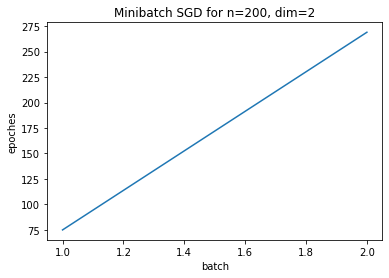

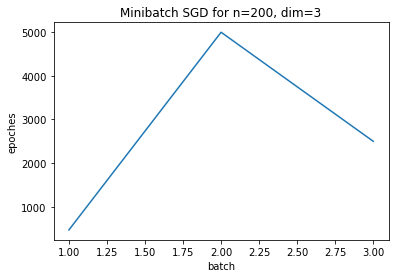

C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:11: RuntimeWarning: overflow encountered in add
  grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1443794645.py:27: RuntimeWarning: invalid value encountered in subtract
  coeffs_step = coeffs - current_lr * grad


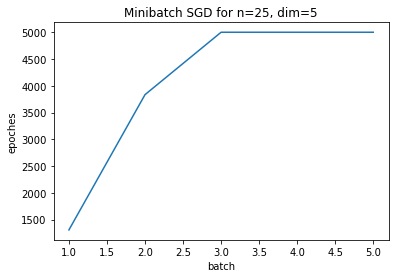

C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:11: RuntimeWarning: overflow encountered in multiply
  grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1443794645.py:27: RuntimeWarning: invalid value encountered in subtract
  coeffs_step = coeffs - current_lr * grad
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:11: RuntimeWarning: overflow encountered in add
  grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:12: RuntimeWarning: overflow encountered in double_scalars
  grad_b += 2 * (a @ points.x[i] + b - points.y[i])


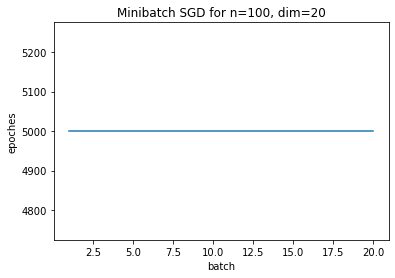

C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:11: RuntimeWarning: overflow encountered in multiply
  grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1443794645.py:27: RuntimeWarning: invalid value encountered in subtract
  coeffs_step = coeffs - current_lr * grad
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:12: RuntimeWarning: overflow encountered in double_scalars
  grad_b += 2 * (a @ points.x[i] + b - points.y[i])


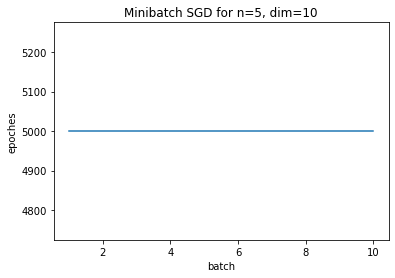

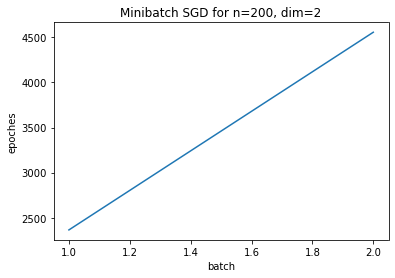

In [32]:
print_batch_size_analyze(input_2d)
print_batch_size_analyze(input_3d)
print_batch_size_analyze(input_small)
print_batch_size_analyze(input_large)
print_batch_size_analyze(input_wild)
print_batch_size_analyze(input_custom)

Микровывод: как можно видеть, mini-batch SGD для лин. регрессии без каких либо оптимизаций действительно сильно "скачет" в показаниях сходимости для ранзных величин batch и размерности пространства точек. В подавляющем большинстве случаев сойтись не получается даже за 5000 эпох :( что подтверждает неэффиктивность вычисления частичного градиента для случайного набора данных.

Однако также, можно заметить следующие моменты:
* не стоит забывать переполнение double
* редко бывают случие, когда бы не сошелся SGD, но сошлись minibatch SGD или GD
* для batch < dim, сходимость достигается (если и достигается) за меньшее число эпох, по сравнению с ГС из лабораторной 1

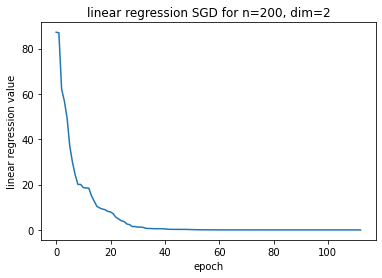

In [33]:
print_linear_regression_epochs(input_2d, 1)

Тем не менее в случаях, когда ГС (СГС) сходится, значения линейной регрессии действительно уменьшаются со временем, а значит, проблема расхождения за 5000 эпох действительно возникает из-за колеблющегося графика минимизирующей функции и констанного learning rate.

Похоже на ситуацию с функций Розенброка из первой лабораторной. Там мы решили эту проблему путем пересчета lr через ступенчатую функцию, и, как видно на графиках ниже, здесь она так же помогла. Следовательно расходимость minibatch SGD без модификаций для большинства расмотренных функций - оправдана

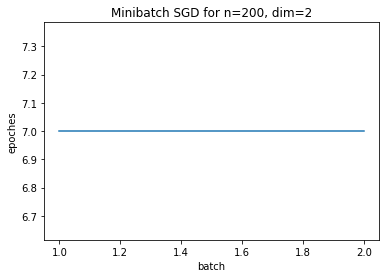

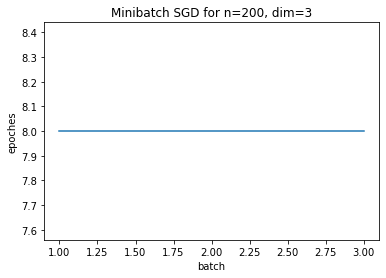

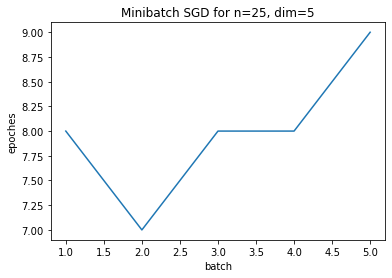

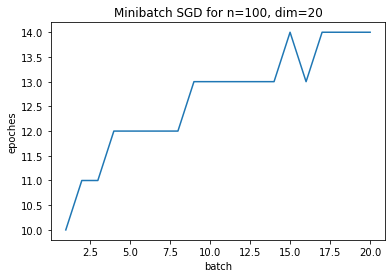

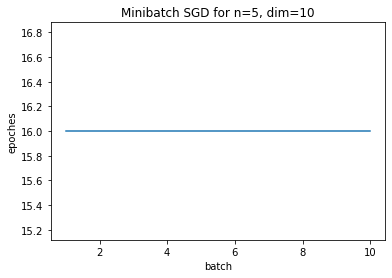

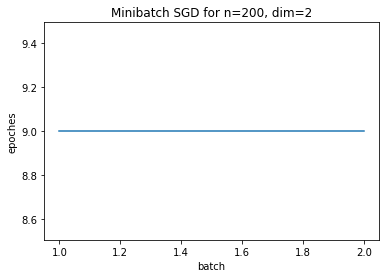

In [34]:
def step_decay(lr, epoch, epochs_drop = 2, drop = 0.5):
   return lr * pow(drop, floor((1 + epoch) / epochs_drop))

print_batch_size_analyze(input_2d, step_decay)
print_batch_size_analyze(input_3d, step_decay)
print_batch_size_analyze(input_small, step_decay)
print_batch_size_analyze(input_large, step_decay)
print_batch_size_analyze(input_wild, step_decay)
print_batch_size_analyze(input_custom, step_decay)

## Пункт 2. Исследовать влияние предварительной нормализации данных на сходимость

Рассмотрим scaling к диапазону [0, 1]

In [35]:
# check if all coords are scaled
def debug_check_scaling(points, l, r):
    ok = 1
    for i in range(0, points.n):    
        for k in range(0, points.dim - 1):
            ok = ok & (l <= points.x[i][k] <= r)
        ok = ok & (l <= points.y[i] <= r)
    return ok

# call sgd with each possible batch_size for point_set & scaled_point_set
# lr - function (current_lr, epoch)
def scaling_batch_size_compare(points, lr = constant_lr):
    epoches_points = batch_size_analyze(points, lr)
    plt.plot(np.linspace(1, len(epoches_points), len(epoches_points)), epoches_points, label='original point set', color='red')
    
    scaled_points = points
    scaled_points = apply_scaling(scaled_points)
    print("check scaling: " + str(debug_check_scaling(scaled_points, 0, 1)))
    epoches_points = batch_size_analyze(scaled_points, lr)
    plt.plot(np.linspace(1, len(epoches_points), len(epoches_points)), epoches_points, label='scaled [0; 1] point set', color='blue')
    
    
    plt.xlabel("batch")
    plt.ylabel("epoches")
    plt.title("Mini-batch SGD for n=" + str(points.n) + ", dim=" + str(points.dim))
    plt.legend()
    plt.show()

check scaling: 1


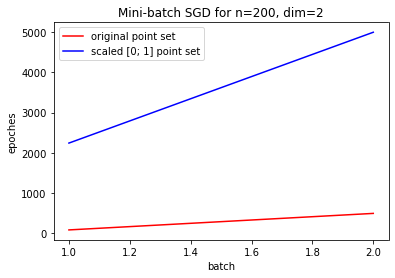

check scaling: 1


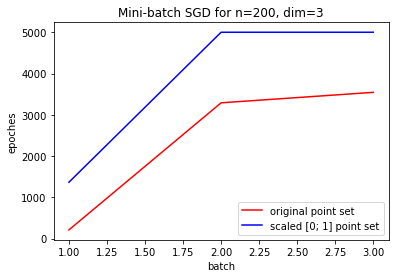

C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:11: RuntimeWarning: overflow encountered in add
  grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1443794645.py:27: RuntimeWarning: invalid value encountered in subtract
  coeffs_step = coeffs - current_lr * grad


check scaling: 1


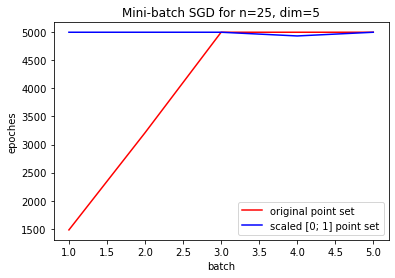

C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:11: RuntimeWarning: overflow encountered in multiply
  grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1443794645.py:27: RuntimeWarning: invalid value encountered in subtract
  coeffs_step = coeffs - current_lr * grad
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:11: RuntimeWarning: overflow encountered in add
  grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:12: RuntimeWarning: overflow encountered in double_scalars
  grad_b += 2 * (a @ points.x[i] + b - points.y[i])


check scaling: 1


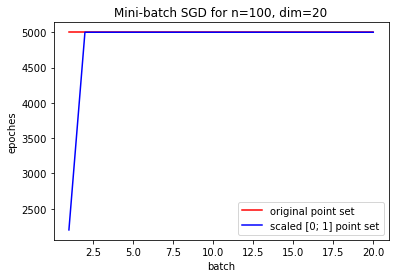

check scaling: 1


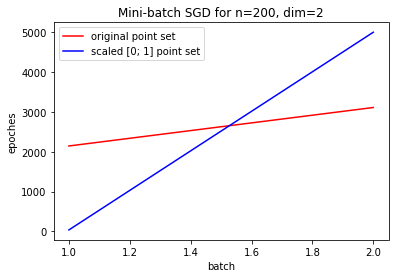

C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:11: RuntimeWarning: overflow encountered in double_scalars
  grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:12: RuntimeWarning: overflow encountered in double_scalars
  grad_b += 2 * (a @ points.x[i] + b - points.y[i])
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1443794645.py:27: RuntimeWarning: invalid value encountered in subtract
  coeffs_step = coeffs - current_lr * grad
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:11: RuntimeWarning: overflow encountered in multiply
  grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
C:\Users\11\AppData\Local\Temp/ipykernel_1548/1405996223.py:11: RuntimeWarning: overflow encountered in add
  grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]


check scaling: 1


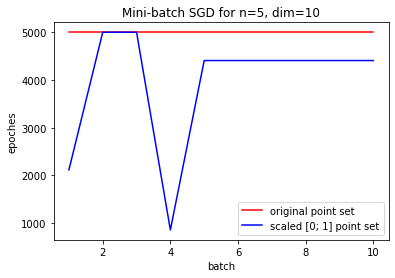

In [36]:
scaling_batch_size_compare(input_2d)
scaling_batch_size_compare(input_3d)
scaling_batch_size_compare(input_small)
scaling_batch_size_compare(input_large)
scaling_batch_size_compare(input_custom)
scaling_batch_size_compare(input_wild)

Микровывод: поскольку набор точек для скаллинга всегда случайный, то нельзя сделать вывод, что скаллинг всегда выигрывает по скорости сходимости у стандартного minibatch SGD. Можно заметить, что чем плотнее изначально расположены точки, тем хуже в вопросе сходимости работает minibatch SGD со скаллингом. Так же ради интереса проверим со ступенчатой функцией: (там вообще летает)

check scaling: 1


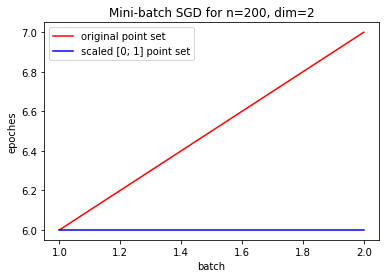

check scaling: 1


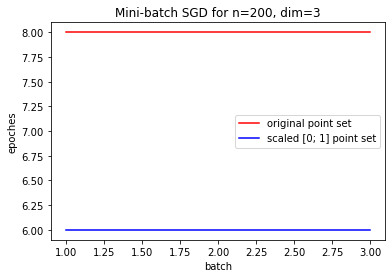

check scaling: 1


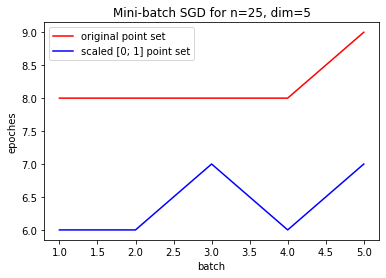

check scaling: 1


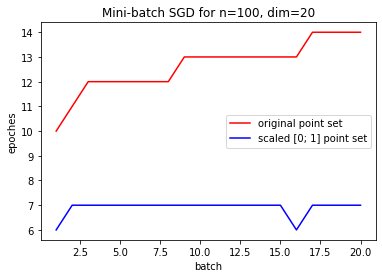

check scaling: 1


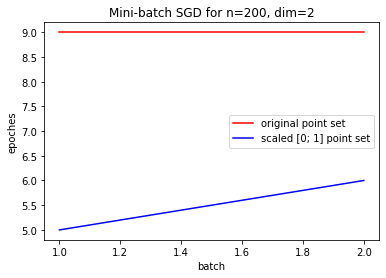

check scaling: 1


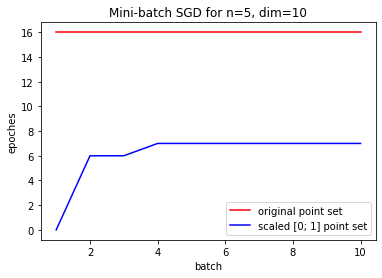

In [38]:
scaling_batch_size_compare(input_2d, step_decay)
scaling_batch_size_compare(input_3d, step_decay)
scaling_batch_size_compare(input_small, step_decay)
scaling_batch_size_compare(input_large, step_decay)
scaling_batch_size_compare(input_custom, step_decay)
scaling_batch_size_compare(input_wild, step_decay)